In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from sklearn.metrics import accuracy_score
import tqdm

import matplotlib.pyplot as plt
import numpy as np

# Define the transforms for the dataset
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])



In [ ]:
# Define the CelebA dataset and loader
dataset = torchvision.datasets.CelebA(root='/content/drive/MyDrive/dataset_celeba', split='train', transform=transform, download=False)
test_dataset = torchvision.datasets.CelebA(root='/content/drive/MyDrive/dataset_celeba', split='test', transform=transform, download=False)

In [ ]:
loader = DataLoader(dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True)

In [ ]:
# Define the ResNet18 model with a modified final layer for multi-task learning
class MultiTaskResNet18(nn.Module):
    def __init__(self, num_classes):
        super(MultiTaskResNet18, self).__init__()
        self.num_classes = num_classes
        self.resnet18 = torchvision.models.resnet18(pretrained=True)
        # remove the last fully connected layer
        self.resnet18.fc = nn.Identity()
        for param in self.resnet18.parameters():
            param.requires_grad = False
        for param in self.resnet18.layer4.parameters():
            param.requires_grad = True

        self.fc_gender = nn.Linear(512, 2)
        self.fc_smiling = nn.Linear(512, 2)
        self.fc_young = nn.Linear(512, 2)
        self.fc_glasses = nn.Linear(512, 2)
        self.fc_hat = nn.Linear(512, 2)
        self.fc_necklace = nn.Linear(512, 2)
        self.fc_earrings = nn.Linear(512, 2)
        self.fc_lipstick = nn.Linear(512, 2)
        
    def forward(self, x):
        x = self.resnet18(x)
        x = x.view(-1, 512)
        out_gender = self.fc_gender(x)
        out_smiling = self.fc_smiling(x)
        out_young = self.fc_young(x)
        out_glasses = self.fc_glasses(x)
        out_hat = self.fc_hat(x)
        out_necklace = self.fc_necklace(x)
        out_earrings = self.fc_earrings(x)
        out_lipstick = self.fc_lipstick(x)

        return out_gender, out_smiling, out_young, out_glasses, out_hat, out_necklace, out_earrings, out_lipstick


#store losses for each task
epoch_losses_gender = []
epoch_losses_smiling = []
epoch_losses_young = []
epoch_losses_glasses = []
epoch_losses_hat = []
epoch_losses_necklace = []
epoch_losses_earrings = []
epoch_losses_lipstick = []


# Define the training loop
def train(model, loader, optimizer, criterion, num_epochs):
    for epoch in range(num_epochs):
        # Set the model to gpu
        model = model.cuda()
        model.train()
        running_loss = 0.0

        running_loss_gender = 0.0
        running_loss_smiling = 0.0
        running_loss_young = 0.0
        running_loss_glasses = 0.0
        running_loss_hat = 0.0
        running_loss_necklace = 0.0
        running_loss_earrings = 0.0
        running_loss_lipstick = 0.0 
        
        for i, data in enumerate(loader,0):
            inputs, targets = data
            inputs = inputs.cuda()
            targets = targets.cuda()
            gender, smiling, young, glasses, hat, necklace, earrings, lipstick = targets[:, 20], targets[:, 31], targets[:, 39], targets[:, 17], targets[:, 2], targets[:, 6], targets[:, 7], targets[:, 4]
            optimizer.zero_grad()
            outputs = model(inputs)
            loss_gender = criterion(outputs[0], gender)
            loss_smiling = criterion(outputs[1], smiling)
            loss_young = criterion(outputs[2], young)
            loss_glasses = criterion(outputs[3], glasses)
            loss_hat = criterion(outputs[4], hat)
            loss_necklace = criterion(outputs[5], necklace)
            loss_earrings = criterion(outputs[6], earrings)
            loss_lipstick = criterion(outputs[7], lipstick)
            loss = loss_gender + loss_smiling + loss_young + loss_glasses + loss_hat + loss_necklace + loss_earrings + loss_lipstick
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            running_loss_gender += loss_gender
            running_loss_smiling += loss_smiling
            running_loss_young += loss_young
            running_loss_glasses += loss_glasses
            running_loss_hat += loss_hat
            running_loss_necklace += loss_necklace
            running_loss_earrings += loss_earrings
            running_loss_lipstick += loss_lipstick

        print(f"Epoch {epoch+1} loss: {running_loss/len(loader)}")

        epoch_losses_gender.append(running_loss_gender/len(loader))
        epoch_losses_smiling.append(running_loss_smiling/len(loader))
        epoch_losses_young.append(running_loss_young/len(loader))
        epoch_losses_glasses.append(running_loss_glasses/len(loader))
        epoch_losses_hat.append(running_loss_hat/len(loader))
        epoch_losses_necklace.append(running_loss_necklace/len(loader))
        epoch_losses_earrings.append(running_loss_earrings/len(loader))
        epoch_losses_lipstick.append(running_loss_lipstick/len(loader))





model = MultiTaskResNet18(num_classes=2)

# Define the loss function and optimizer for training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model, loader, optimizer, criterion, num_epochs=10)

Epoch 1 loss: 1.8634889135195774
Epoch 2 loss: 1.6764656790772323
Epoch 3 loss: 1.550884153295613
Epoch 4 loss: 1.3751914934167322
Epoch 5 loss: 1.1226177940953452
Epoch 6 loss: 0.7756763532664042
Epoch 7 loss: 0.48496983279971956
Epoch 8 loss: 0.31265871437653053
Epoch 9 loss: 0.23292772742515466
Epoch 10 loss: 0.1934398588777151


In [ ]:
for i in range(10):
    epoch_losses_gender[i] = epoch_losses_gender[i].item()
    epoch_losses_smiling[i] = epoch_losses_smiling[i].item()
    epoch_losses_young[i] = epoch_losses_young[i].item()
    epoch_losses_glasses[i] = epoch_losses_glasses[i].item()
    epoch_losses_hat[i] = epoch_losses_hat[i].item()
    epoch_losses_necklace[i] = epoch_losses_necklace[i].item()
    epoch_losses_earrings[i] = epoch_losses_earrings[i].item()
    epoch_losses_lipstick[i] = epoch_losses_lipstick[i].item()

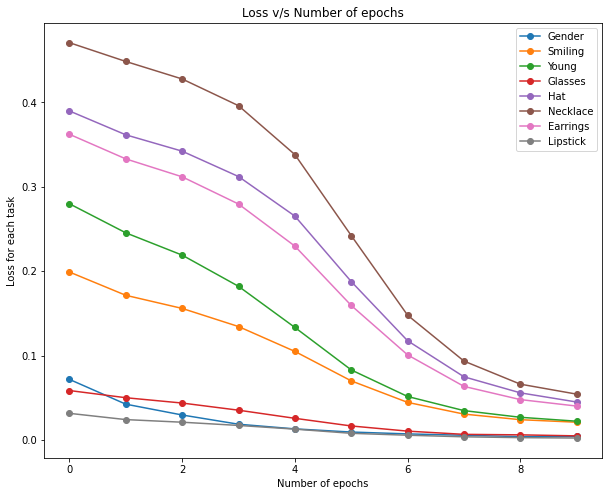

In [ ]:
#Plot epoch_losses for each task v/s number of epochs
plot_epochs = [i for i in range(1,11)]



plt.figure(figsize=(10,8))
plt.title('Loss v/s Number of epochs')
plt.ylabel('Loss for each task')
plt.xlabel('Number of epochs')

# add legends

plt.plot(epoch_losses_gender,'-o', label = 'Gender')
plt.plot(epoch_losses_smiling,'-o', label = 'Smiling')
plt.plot(epoch_losses_young,'-o', label = 'Young')
plt.plot(epoch_losses_glasses,'-o', label = 'Glasses')
plt.plot(epoch_losses_hat,'-o', label = 'Hat')
plt.plot(epoch_losses_necklace,'-o', label = 'Necklace')
plt.plot(epoch_losses_earrings,'-o', label = 'Earrings')
plt.plot(epoch_losses_lipstick,'-o', label = 'Lipstick')

plt.legend()

In [ ]:


model.eval()
gender_preds = []
smiling_preds = []
young_preds = []
glasses_preds = []
hat_preds = []
necklace_preds = []
earrings_preds = []
lipstick_preds = []
gender_labels = []
smiling_labels = []
young_labels = []
glasses_labels = []
hat_labels = []
necklace_labels = []
earrings_labels = []
lipstick_labels = []

with torch.no_grad():
    for data in test_loader:
        inputs, targets = data
        inputs = inputs.cuda()
        targets = targets.cuda()
        gender, smiling, young, glasses, hat, necklace, earrings, lipstick = targets[:, 20], targets[:, 31], targets[:, 39], targets[:, 17], targets[:, 2], targets[:, 6], targets[:, 7], targets[:, 4]
        outputs = model(inputs)
        gender_preds.extend(torch.argmax(outputs[0], dim=1).tolist())
        smiling_preds.extend(torch.argmax(outputs[1], dim=1).tolist())
        young_preds.extend(torch.argmax(outputs[2], dim=1).tolist())
        glasses_preds.extend(torch.argmax(outputs[3], dim=1).tolist())
        hat_preds.extend(torch.argmax(outputs[4], dim=1).tolist())
        necklace_preds.extend(torch.argmax(outputs[5], dim=1).tolist())
        earrings_preds.extend(torch.argmax(outputs[6], dim=1).tolist())
        lipstick_preds.extend(torch.argmax(outputs[7], dim=1).tolist())
        gender_labels.extend(gender.tolist())
        smiling_labels.extend(smiling.tolist())
        young_labels.extend(young.tolist())
        glasses_labels.extend(glasses.tolist())
        hat_labels.extend(hat.tolist())
        necklace_labels.extend(necklace.tolist())
        earrings_labels.extend(earrings.tolist())
        lipstick_labels.extend(lipstick.tolist())


gender_acc = accuracy_score(gender_labels, gender_preds)
smiling_acc = accuracy_score(smiling_labels, smiling_preds)
young_acc = accuracy_score(young_labels, young_preds)
glasses_acc = accuracy_score(glasses_labels, glasses_preds)
hat_acc = accuracy_score(hat_labels, hat_preds)
necklace_acc = accuracy_score(necklace_labels, necklace_preds)
earrings_acc = accuracy_score(earrings_labels, earrings_preds)
lipstick_acc = accuracy_score(lipstick_labels, lipstick_preds)

print(f"Gender accuracy: {gender_acc}")
print(f"Smiling accuracy: {smiling_acc}")
print(f"Young accuracy: {young_acc}")
print(f"Glasses accuracy: {glasses_acc}")
print(f"Hat accuracy: {hat_acc}")
print(f"Necklace accuracy: {necklace_acc}")
print(f"Earrings accuracy: {earrings_acc}")
print(f"Lipstick accuracy: {lipstick_acc}")

Gender accuracy: 0.9688407975152791
Smiling accuracy: 0.911582005811041
Young accuracy: 0.8638412984670875
Glasses accuracy: 0.97956116621581
Hat accuracy: 0.7972147079450956
Necklace accuracy: 0.6718765654744013
Earrings accuracy: 0.8152489730487927
Lipstick accuracy: 0.9877767758741609


In [ ]:
all_labels = gender_labels+smiling_labels+young_labels+glasses_labels+hat_labels+necklace_labels+earrings_labels+lipstick_labels
all_preds = gender_preds+smiling_preds+young_preds+glasses_preds+hat_preds+necklace_preds+earrings_preds+lipstick_preds

In [ ]:
overall_acc = accuracy_score(all_labels, all_preds)
print(f"Overall accuracy: {overall_acc}")

Overall accuracy: 0.8744927862939585


Question 2

In [ ]:
Attributes = ['Gender', 'Smiling', 'Young', 'Wearing Glasses', 'Wearing Hat', 'Wearing Necklace', 'Wearing Earrings', 'Wearing Lipstick']

Drop rate using Metric based on Network Depth

In [ ]:
# Calulate the number of layers in the model
num_layers = 0
for layer in model.children():
    num_layers += 1

num_layers += 1 # Add 1 for the final linear layer

# Print the number of layers in the model
print(f"Number of layers in the model: {num_layers}")

Number of layers in the model: 10


In [ ]:
# Print the model architecture
print(model)

MultiTaskResNet18(
  (resnet18): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [ ]:
# The depth of each task will be equal to the number of layers in the model according to our model architecture
depth_for_each_task = num_layers

for i in range(len(Attributes)):
    print(f"Drop Rate based on Network Depth for {Attributes[i]}: {depth_for_each_task/num_layers}")

Drop Rate based on Network Depth for Gender: 1.0
Drop Rate based on Network Depth for Smiling: 1.0
Drop Rate based on Network Depth for Young: 1.0
Drop Rate based on Network Depth for Wearing Glasses: 1.0
Drop Rate based on Network Depth for Wearing Hat: 1.0
Drop Rate based on Network Depth for Wearing Necklace: 1.0
Drop Rate based on Network Depth for Wearing Earrings: 1.0
Drop Rate based on Network Depth for Wearing Lipstick: 1.0


Drop Rate based on metric based on Task Incompleteness

In [ ]:
task_wise_losses = []

task_wise_losses.append(epoch_losses_gender)
task_wise_losses.append(epoch_losses_smiling)
task_wise_losses.append(epoch_losses_young)
task_wise_losses.append(epoch_losses_glasses)
task_wise_losses.append(epoch_losses_hat)
task_wise_losses.append(epoch_losses_necklace)
task_wise_losses.append(epoch_losses_earrings)
task_wise_losses.append(epoch_losses_lipstick)


In [ ]:
#Incompleteness for each task

#Find ratio of 1st epoch loss to 10th epoch loss for each task
loss_ratio = []    # I(10, t)

for i in range(len(Attributes)):
    loss_ratio.append(task_wise_losses[i][9]/task_wise_losses[i][0])

expected_val_at_10th_epoch = np.mean(loss_ratio) #E(I(10, t))

# Relative Incompleteness for each task
relative_incompleteness = []  # min(1, I(10, t)/E(I(10, t)) )

for i in range(len(Attributes)):
    relative_incompleteness.append(min(1, loss_ratio[i]/expected_val_at_10th_epoch))

    print(f"Relative Incompleteness for {Attributes[i]}: {relative_incompleteness[i]}")
    



Relative Incompleteness for Gender: 0.6260592080230313
Relative Incompleteness for Smiling: 1
Relative Incompleteness for Young: 0.8617230068700827
Relative Incompleteness for Wearing Glasses: 0.889436204908604
Relative Incompleteness for Wearing Hat: 1
Relative Incompleteness for Wearing Necklace: 1
Relative Incompleteness for Wearing Earrings: 1
Relative Incompleteness for Wearing Lipstick: 0.765159548862277


In [ ]:
loss_ratio

[0.05751930951692053,
 0.10530718960709223,
 0.07917096612400328,
 0.08171712149597693,
 0.11514838693009333,
 0.1151883445515038,
 0.11065103241728827,
 0.07029917994468265]

In [ ]:
expected_val_at_10th_epoch

0.09187519132344513

Using Drop Rate based on Task Incompleteness Metric, The DST(Dropped Scheduled Task) Algorithm is implemented

In [ ]:
def bernoulli(relative_incompleteness):

    bernoulli = []
    for i in range(8):
        bernoulli.append(np.random.binomial(1,relative_incompleteness[i]))
    # Return the bernoulli output
    return bernoulli

In [ ]:
print(bernoulli(relative_incompleteness))

[0, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
task_wise_losses = [[] for i in range(8)]

[[], [], [], [], [], [], [], []]

In [ ]:
# Define the training loop
def train(model, loader, optimizer, criterion, num_epochs):
    for epoch in range(num_epochs):
        # Set the model to gpu
        model = model.cuda()
        model.train()
        running_loss = 0.0

        running_loss_gender = 0.0
        running_loss_smiling = 0.0
        running_loss_young = 0.0
        running_loss_glasses = 0.0
        running_loss_hat = 0.0
        running_loss_necklace = 0.0
        running_loss_earrings = 0.0
        running_loss_lipstick = 0.0 
        
        for i, data in enumerate(loader,0):
            inputs, targets = data
            inputs = inputs.cuda()
            targets = targets.cuda()
            gender, smiling, young, glasses, hat, necklace, earrings, lipstick = targets[:, 20], targets[:, 31], targets[:, 39], targets[:, 17], targets[:, 2], targets[:, 6], targets[:, 7], targets[:, 4]
            optimizer.zero_grad()
            outputs = model(inputs)
            loss_gender = criterion(outputs[0], gender)
            loss_smiling = criterion(outputs[1], smiling)
            loss_young = criterion(outputs[2], young)
            loss_glasses = criterion(outputs[3], glasses)
            loss_hat = criterion(outputs[4], hat)
            loss_necklace = criterion(outputs[5], necklace)
            loss_earrings = criterion(outputs[6], earrings)
            loss_lipstick = criterion(outputs[7], lipstick)

#############################################################################
            ##DST Algorithm Implementation using Task Incompleteness metric
            relative_incompleteness = []
            
            if(epoch !=0):
                #Find ratio of 1st epoch loss to kth epoch loss for each task
                loss_ratio = []    # I(k, t)

                for i in range(len(Attributes)):
                    loss_ratio.append(task_wise_losses[i][epoch-1]/task_wise_losses[i][0])

                expected_val_at_kth_epoch = np.mean(loss_ratio) #E(I(k, t))

                # Relative Incompleteness for each task
                # min(1, I(k, t)/E(I(k, t)) )

                for i in range(len(Attributes)):
                    relative_incompleteness.append(min(1, loss_ratio[i]/expected_val_at_kth_epoch))


            ber = []
            if(epoch == 0):
                ber = [1,1,1,1,1,1,1,1]
            
            else:
                ber = bernoulli(relative_incompleteness)



            loss = ber[0]*loss_gender + ber[1]*loss_smiling + ber[2]*loss_young + ber[3]*loss_glasses + ber[4]*loss_hat + ber[5]*loss_necklace + ber[6]*loss_earrings + ber[7]*loss_lipstick

#############################################################################


            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            running_loss_gender += loss_gender
            running_loss_smiling += loss_smiling
            running_loss_young += loss_young
            running_loss_glasses += loss_glasses
            running_loss_hat += loss_hat
            running_loss_necklace += loss_necklace
            running_loss_earrings += loss_earrings
            running_loss_lipstick += loss_lipstick

        print(f"Epoch {epoch+1} loss: {running_loss/len(loader)}")
        
        task_wise_losses[0].append((running_loss_gender/len(loader)).item())
        task_wise_losses[1].append((running_loss_smiling/len(loader)).item())
        task_wise_losses[2].append((running_loss_young/len(loader)).item())
        task_wise_losses[3].append((running_loss_glasses/len(loader)).item())
        task_wise_losses[4].append((running_loss_hat/len(loader)).item())
        task_wise_losses[5].append((running_loss_necklace/len(loader)).item())
        task_wise_losses[6].append((running_loss_earrings/len(loader)).item())
        task_wise_losses[7].append((running_loss_lipstick/len(loader)).item())






model = MultiTaskResNet18(num_classes=2)

# Define the loss function and optimizer for training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model, loader, optimizer, criterion, num_epochs=10)

Epoch 1 loss: 1.8636206000481013
Epoch 2 loss: 1.6751287410844047
Epoch 3 loss: 1.5368540566297446
Epoch 4 loss: 1.3689731441953648
Epoch 5 loss: 1.1191801042676721
Epoch 6 loss: 0.7899344633772688
Epoch 7 loss: 0.4989400660185694
Epoch 8 loss: 0.33030131250713607
Epoch 9 loss: 0.2468746958546481
Epoch 10 loss: 0.20452097222302695


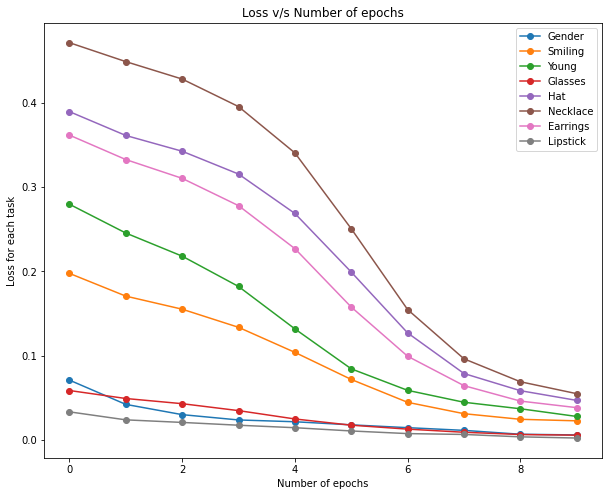

In [ ]:
#Plot epoch_losses for each task v/s number of epochs
plot_epochs = [i for i in range(1,11)]



plt.figure(figsize=(10,8))
plt.title('Loss v/s Number of epochs')
plt.ylabel('Loss for each task')
plt.xlabel('Number of epochs')

# add legends

plt.plot(task_wise_losses[0],'-o', label = 'Gender')
plt.plot(task_wise_losses[1],'-o', label = 'Smiling')
plt.plot(task_wise_losses[2],'-o', label = 'Young')
plt.plot(task_wise_losses[3],'-o', label = 'Glasses')
plt.plot(task_wise_losses[4],'-o', label = 'Hat')
plt.plot(task_wise_losses[5],'-o', label = 'Necklace')
plt.plot(task_wise_losses[6],'-o', label = 'Earrings')
plt.plot(task_wise_losses[7],'-o', label = 'Lipstick')

plt.legend()

In [ ]:


model.eval()
gender_preds = []
smiling_preds = []
young_preds = []
glasses_preds = []
hat_preds = []
necklace_preds = []
earrings_preds = []
lipstick_preds = []
gender_labels = []
smiling_labels = []
young_labels = []
glasses_labels = []
hat_labels = []
necklace_labels = []
earrings_labels = []
lipstick_labels = []

with torch.no_grad():
    for data in test_loader:
        inputs, targets = data
        inputs = inputs.cuda()
        targets = targets.cuda()
        gender, smiling, young, glasses, hat, necklace, earrings, lipstick = targets[:, 20], targets[:, 31], targets[:, 39], targets[:, 17], targets[:, 2], targets[:, 6], targets[:, 7], targets[:, 4]
        outputs = model(inputs)
        gender_preds.extend(torch.argmax(outputs[0], dim=1).tolist())
        smiling_preds.extend(torch.argmax(outputs[1], dim=1).tolist())
        young_preds.extend(torch.argmax(outputs[2], dim=1).tolist())
        glasses_preds.extend(torch.argmax(outputs[3], dim=1).tolist())
        hat_preds.extend(torch.argmax(outputs[4], dim=1).tolist())
        necklace_preds.extend(torch.argmax(outputs[5], dim=1).tolist())
        earrings_preds.extend(torch.argmax(outputs[6], dim=1).tolist())
        lipstick_preds.extend(torch.argmax(outputs[7], dim=1).tolist())
        gender_labels.extend(gender.tolist())
        smiling_labels.extend(smiling.tolist())
        young_labels.extend(young.tolist())
        glasses_labels.extend(glasses.tolist())
        hat_labels.extend(hat.tolist())
        necklace_labels.extend(necklace.tolist())
        earrings_labels.extend(earrings.tolist())
        lipstick_labels.extend(lipstick.tolist())


gender_acc_new = accuracy_score(gender_labels, gender_preds)
smiling_acc_new = accuracy_score(smiling_labels, smiling_preds)
young_acc_new = accuracy_score(young_labels, young_preds)
glasses_acc_new = accuracy_score(glasses_labels, glasses_preds)
hat_acc_new = accuracy_score(hat_labels, hat_preds)
necklace_acc_new = accuracy_score(necklace_labels, necklace_preds)
earrings_acc_new = accuracy_score(earrings_labels, earrings_preds)
lipstick_acc_new = accuracy_score(lipstick_labels, lipstick_preds)

print(f"Gender accuracy: {gender_acc_new}")
print(f"Smiling accuracy: {smiling_acc_new}")
print(f"Young accuracy: {young_acc_new}")
print(f"Glasses accuracy: {glasses_acc_new}")
print(f"Hat accuracy: {hat_acc_new}")
print(f"Necklace accuracy: {necklace_acc_new}")
print(f"Earrings accuracy: {earrings_acc_new}")
print(f"Lipstick accuracy: {lipstick_acc_new}")

Gender accuracy: 0.9781084059713455
Smiling accuracy: 0.9127842901512875
Young accuracy: 0.8661456767858932
Glasses accuracy: 0.9807634505560565
Hat accuracy: 0.7967638513175033
Necklace accuracy: 0.7024847209698427
Earrings accuracy: 0.8305280032060915
Lipstick accuracy: 0.9888287746718766


In [ ]:
all_labels_new = gender_labels+smiling_labels+young_labels+glasses_labels+hat_labels+necklace_labels+earrings_labels+lipstick_labels
all_preds_new = gender_preds+smiling_preds+young_preds+glasses_preds+hat_preds+necklace_preds+earrings_preds+lipstick_preds

In [ ]:
overall_acc_new = accuracy_score(all_labels_new, all_preds_new)
print(f"Overall accuracy: {overall_acc_new}")

Overall accuracy: 0.8820508967037372


<ipython-input-73-153dcb1be5af>:22: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(x + width, att)


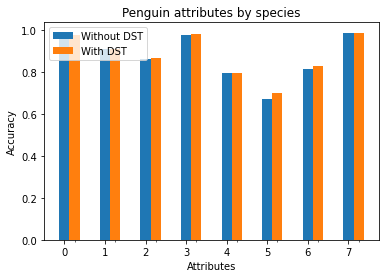

In [ ]:
att = ['Gender', 'Smiling', 'Young', 'Glasses', 'Hat', 'Necklace', 'Earrings', 'Lipstick']
vals = {
    'Without DST': (gender_acc, smiling_acc, young_acc, glasses_acc, hat_acc, necklace_acc, earrings_acc, lipstick_acc),
    'With DST': (gender_acc_new, smiling_acc_new, young_acc_new, glasses_acc_new, hat_acc_new, necklace_acc_new, earrings_acc_new, lipstick_acc_new),
}

x = np.arange(len(att))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots()

for attribute, measurement in vals.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    multiplier += 1


ax.set_ylabel('Accuracy')
ax.set_xlabel('Attributes')
ax.set_title('Penguin attributes by species')
ax.set_xticks(x + width, att)
ax.legend(loc='upper left')
#ax.set_ylim(0, 250)

plt.show()

